In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

research = pd.read_csv('OP_DTL_RSRCH_PGYR2017_P01182019.csv')
general = pd.read_csv('OP_DTL_GNRL_PGYR2017_P01182019.csv')

In [2]:
sample_research = research.sample(n=10000, random_state=1) # sample 10000 from research
sample_general = general.sample(n=10000, random_state=1) # sample 10000 from general 

## Task 1 Identify Features
- Assemble a dataset consisting of features and target 

In [3]:
research_col = sample_research.columns.values
general_col = sample_general.columns.values
common_feature = list(set(list(research_col)) & set(list(general_col)))

In [4]:
research_1 = sample_research[common_feature]
general_1 = sample_general[common_feature]
research_1['y'] = [0] * 10000
general_1['y'] = [1] * 10000

In [5]:
data = research_1.append(general_1)
data.index = range(20000)

- What features are relevant for the prediction task?
- What features should be excluded because they leak the target information?

I first extracted the common features in research and general datasets. These features are relevent for the prediction. Now let's modify some of those features. 

modify zipcode: to same type 

In [6]:
zip = data['Recipient_Zip_Code'].copy()

In [7]:
for index in zip.index.values:
    if pd.isnull(zip[index]) == False:
        if type(zip[index]) == str:
            if len(zip[index]) > 5:
                zip[index] = zip[index][0:5] 
        else:
            zip[index] = str(int(zip[index]))

In [8]:
data['Recipient_Zip_Code'] = zip

modify IDs: All features related to ID should be in type string not float.

In [9]:
pp_id = data['Physician_Profile_ID'].copy()
gpo_id = data['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'].copy()

new_ppid = []
new_gpoid = []
for index in range(20000):
    value = pp_id[index] 
    value2 = gpo_id[index]
    if pd.isnull(value) == False:
        new_ppid.append(str(int(value)))
    else:
        new_ppid.append(value)
        
    if pd.isnull(value2) == False:
        new_gpoid.append(str(int(value2)))
    else:
        new_gpoid.append(value2)

In [10]:
data['Physician_Profile_ID'] = new_ppid
data['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID'] = new_gpoid

If the number of a feature's nan value is greater than half of length, do not include that feature.

In [11]:
left_feature = []
for feature in data.columns.values:
    temp = data[feature]
    if sum(pd.isnull(temp))/len(temp) < 0.5:
        left_feature.append(feature)

If the unique values in that feature is only one or 20000. then delete that feature

'Program_Year', length = 1, all 2017 

'Delay_in_Publication_Indicator', length = 1, all NO

'Payment_Publication_Date', length = 1, all 01/18/2019

'Record_ID', length = 20000

In [12]:
left_feature_2 = []
for col in left_feature:
    x = data[col].values
    length = len(np.unique(x[pd.notnull(x)]))
    if 1 < length & length < 20000:
        left_feature_2.append(col)

In [13]:
len(left_feature_2)

29

delete features based on descriptions:

delete 'Covered_Recipient_Type'

In [14]:
np.unique(sample_research['Covered_Recipient_Type'].values)

array(['Covered Recipient Physician',
       'Covered Recipient Teaching Hospital',
       'Non-covered Recipient Entity', 'Non-covered Recipient Individual'],
      dtype=object)

In [15]:
np.unique(sample_general['Covered_Recipient_Type'].values)

array(['Covered Recipient Physician',
       'Covered Recipient Teaching Hospital'], dtype=object)

We can see that in research, levels are four. But in general, levels are only one. In general dataset, the 'Covered_Recipient_Type' does not have levels 'Non-covered Recipient Entity' and 'Non-covered Recipient Individual'. So this feature leaks the information of target information. We should exclude this feature. 

In [16]:
left_feature_2.remove('Covered_Recipient_Type') # exclude Covered_Recipient_Type

In [17]:
df = data[left_feature_2]
df.shape

(20000, 28)

## Task 2 Preprocessing and Baseline Model


let's first remove a couple of features.  

'Recipient_Primary_Business_Street_Address_Line1' and 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name' has too many levels

'Physician_First_Name' and 'physician_Last_Name' seem redundant as Physician_Profile_ID can uniquely define a physician 

In [18]:
left_feature_2.remove('Recipient_Primary_Business_Street_Address_Line1')
left_feature_2.remove('Physician_First_Name')
left_feature_2.remove('Physician_Last_Name')
left_feature_2.remove('Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name')
df = data[left_feature_2]
df.shape

(20000, 24)

In [19]:
y = df['y'].copy()
X = df.loc[:, df.columns != 'y'].copy() #23

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
continuous = ['Total_Amount_of_Payment_USDollars']
categorical = list(set(X_train.columns) - set(continuous))

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler


cat_encoder = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'constant', 
                                                          fill_value = 'N/A')),
                               ('encoder', 
                                OneHotEncoder(categories=[X_train[var].unique() 
                                                                     for var in categorical],
                                                        handle_unknown = 'ignore'))])
preprocess = make_column_transformer((continuous, SimpleImputer(strategy='median')), 
                                     (categorical, cat_encoder))

/anaconda3/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:739: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [23]:
pipeline = make_pipeline(preprocess, LogisticRegression())
val_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
val_scores.mean()

0.9560639514071058

In [24]:
pipeline.fit(X_train, y_train)
pipeline.score(X_train, y_train)
pipeline.score(X_test, y_test)


0.9572

Use logistic regression, we got score = 0.9572

## Task 3 Feature Engineering

In [25]:
highlevel = []
for i in categorical:
    x = X_train[i].values
    length = len(np.unique(x[pd.notnull(x)]))
    if length > 100:
        highlevel.append(i)


In [26]:
normal_category = list(set(categorical) - set(highlevel))

In [27]:
X_train = X_train.replace(to_replace={var:np.NaN for var in categorical}, 
                      value="N/A")
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [28]:
from category_encoders import TargetEncoder


highlevel_encoder = Pipeline(steps = [('encoder', TargetEncoder())])
normal_cat_encoder = Pipeline(steps = [('encoder', 
                                        OneHotEncoder(categories=[X_train[var].unique() 
                                                                  for var in normal_category],
                                                        handle_unknown = 'ignore'))])

preprocess = make_column_transformer((continuous, SimpleImputer(strategy='median')), 
                                     (normal_category, normal_cat_encoder),
                                    (highlevel, highlevel_encoder))
pipeline = make_pipeline(preprocess, LogisticRegression())


val_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
val_scores.mean()

/anaconda3/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:739: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


0.9768003979555997

Our model is improved as the score increased to 0.977

## Task 4 Any model

### Random Forest 

In [29]:
from sklearn.ensemble import RandomForestClassifier
train_scores = []
test_scores = []

rf = RandomForestClassifier(warm_start=True, random_state=1)
X_test = X_test.replace(to_replace={var:np.NaN for var in categorical}, 
                          value="N/A")
estimator_range = range(1, 150, 5)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    pipeline2 = make_pipeline(preprocess, rf)
    pipeline2.fit(X_train, y_train)
    train_scores.append(pipeline2.score(X_train, y_train))
    test_scores.append(pipeline2.score(X_test, y_test))


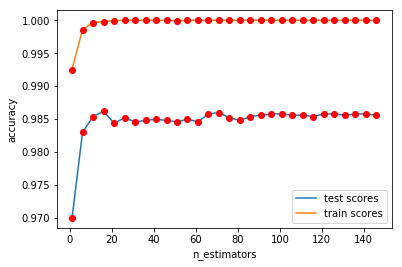

In [30]:
plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.plot(list(estimator_range), train_scores,'ro')
plt.plot(list(estimator_range), test_scores,'ro')
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()

In [31]:
test_scores
score_n = pd.DataFrame({'n_estimators':list(range(1, 150, 5)), 
                        'test_scores':test_scores})
score_n

,n_estimators,test_scores
0,1,0.9700
1,6,0.9830
2,11,0.9854
3,16,0.9862
4,21,0.9844
5,26,0.9852
6,31,0.9846
7,36,0.9848
8,41,0.9850
9,46,0.9848


In [32]:
rf = RandomForestClassifier(n_estimators = 41,random_state=0)
pipe = make_pipeline(preprocess, rf)
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

1.0
0.9838


### gradient boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [34]:
gbrt = GradientBoostingClassifier(random_state = 0)
pipe = make_pipeline(preprocess, gbrt)
param_grid = {'gradientboostingclassifier__learning_rate': [.2, .1, .05, .02, .01],
             'gradientboostingclassifier__max_depth':[5,10,20,30]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5,
                   return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__max_depth': 10}
0.9852


In [35]:
gbrt = GradientBoostingClassifier(learning_rate = 0.2,
                                  random_state = 0, max_depth=10)
pipe_gbrt = make_pipeline(preprocess, gbrt)
pipe_gbrt.fit(X_train, y_train)
print(pipe_gbrt.score(X_train, y_train))
print(pipe_gbrt.score(X_test, y_test))

1.0
0.9852


I tried Random Forest and Gradient Boosting. Based on the scores, Gradient Boosting is better 

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential, and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?


### gradient boost

In [36]:
name1 = pipe_gbrt.named_steps['columntransformer'].named_transformers_[
    'pipeline-1'].named_steps['encoder'].get_feature_names()
name2 = pipe_gbrt.named_steps['columntransformer'].named_transformers_[
    'pipeline-2'].named_steps['encoder'].get_feature_names()
name = continuous + list(name1) + list(name2)
imp = pd.DataFrame({'feature':name, 'importance':gbrt.feature_importances_})
#imp.sort_values('importance',ascending=False)


In [37]:
temp = [0]*imp.shape[0]
for i in range(imp.shape[0]):
    if i <185:
        if imp['feature'][i][0] == 'x':
            temp[i] = imp['feature'][i][0:2]
        else:
            temp[i] = imp['feature'][i]
    else: 
        if imp['feature'][i][0] == 'x':
            temp[i] = imp['feature'][i][0:3]
        else:
            temp[i] = imp['feature'][i]

In [38]:
imp['temp'] = temp

In [39]:
x = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11']
table = pd.DataFrame({'temp':x, 'name': normal_category})
s1 = pd.merge(imp, table, how='left', on=['temp'])

In [40]:
for i in range(s1.shape[0]):
  
    if s1['feature'][i][0] != 'x':
        s1['name'][i] = s1['feature'][i]
    

In [41]:
s1 = s1.drop(columns=['temp'])


In [42]:
zero_importance_features = np.unique(s1.loc[s1['importance'] == 0,:]['name'].values)

In [43]:
nonzero_importance_features = np.unique(s1.loc[s1['importance'] > 0,:]['name'].values)

In [44]:
no_influence_features = list(set(nonzero_importance_features) 
                             - set(zero_importance_features))

for i in no_influence_features:
    print(i)


Recipient_Zip_Code
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1
Associated_Drug_or_Biological_NDC_1
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID
Change_Type
Covered_or_Noncovered_Indicator_1
Product_Category_or_Therapeutic_Area_1
Recipient_City
Total_Amount_of_Payment_USDollars
Date_of_Payment
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1
Physician_Specialty
Physician_Profile_ID
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name


Those features above all have 0 importance values, which could be removed without decrease in performance. 

In [45]:
s1.sort_values('importance',ascending=False)

,feature,importance,name
199,Physician_Profile_ID,0.920647,Physician_Profile_ID
197,Applicable_Manufacturer_or_Applicable_GPO_Maki...,0.016315,Applicable_Manufacturer_or_Applicable_GPO_Maki...
0,Total_Amount_of_Payment_USDollars,0.015508,Total_Amount_of_Payment_USDollars
195,Name_of_Drug_or_Biological_or_Device_or_Medica...,0.007397,Name_of_Drug_or_Biological_or_Device_or_Medica...
192,Recipient_Zip_Code,0.006714,Recipient_Zip_Code
198,Date_of_Payment,0.004734,Date_of_Payment
201,Submitting_Applicable_Manufacturer_or_Applicab...,0.003583,Submitting_Applicable_Manufacturer_or_Applicab...
193,Product_Category_or_Therapeutic_Area_1,0.003122,Product_Category_or_Therapeutic_Area_1
59,x3_NC,0.002674,Applicable_Manufacturer_or_Applicable_GPO_Maki...
200,Physician_Specialty,0.002626,Physician_Specialty


In [46]:
top8_influential_features = list(s1.sort_values(
    'importance',ascending=False)['feature'].values[0:8])
for i in top8_influential_features:
    print(i)

Physician_Profile_ID
Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID
Total_Amount_of_Payment_USDollars
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1
Recipient_Zip_Code
Date_of_Payment
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name
Product_Category_or_Therapeutic_Area_1


Those features above are most influential based on their importance score

### Does removing irrelevant features make your model better?

In [47]:
X_train_drop = X_train.copy()
X_train_drop = X_train_drop.drop(no_influence_features,axis=1)

X_test_drop = X_test.copy()
X_test_drop = X_test_drop.drop(no_influence_features,axis=1)

In [48]:
cat = X_train_drop.columns
highlevel = []
for i in cat:
    x = X_train_drop[i].values
    length = len(np.unique(x[pd.notnull(x)]))
    if length > 100:
        highlevel.append(i)
## no high level, no continuous 

In [49]:
from sklearn.compose import ColumnTransformer
#preprocess = make_column_transformer((cat, OneHotEncoder()))
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat)])

In [50]:
gbrt = GradientBoostingClassifier(random_state = 0)
pipeline = make_pipeline(preprocessor, gbrt)
param_grid = {'gradientboostingclassifier__learning_rate': [.2, .1, .05, .02, .01],
             'gradientboostingclassifier__max_depth':[5,10,20,30]}


grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5,
                   return_train_score=True)
grid.fit(X_train_drop, y_train)
print(grid.best_params_)
print(grid.score(X_test_drop, y_test))

{'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__max_depth': 5}
0.9756


So removing irrelevant features does not make model better

## Task 6 An explainable model
Let's fit a tree using top 8 important features

In [51]:
top8_influential_features 

['Physician_Profile_ID',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID',
 'Total_Amount_of_Payment_USDollars',
 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Recipient_Zip_Code',
 'Date_of_Payment',
 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
 'Product_Category_or_Therapeutic_Area_1']

In [52]:
X_train_infl = X_train.copy()
X_train_infl = X_train_infl[top8_influential_features]

X_test_infl = X_test.copy()
X_test_infl = X_test_infl[top8_influential_features]

In [53]:
categorical = X_train_infl.columns

highlevel = []
for i in categorical:
    x = X_train_infl[i].values
    length = len(np.unique(x[pd.notnull(x)]))
    if length > 100:
        highlevel.append(i)


In [54]:
normal_category = list(set(categorical) - set(highlevel))

In [55]:
from sklearn.tree import DecisionTreeClassifier
highlevel_encoder = Pipeline(steps = [('encoder', TargetEncoder())])
normal_cat_encoder = Pipeline(steps = [('encoder', OneHotEncoder(categories=[X_train_infl[var].unique() for var in normal_category],
                                                        handle_unknown = 'ignore'))])

preprocess = make_column_transformer((continuous, SimpleImputer(strategy='median')), 
                                     (normal_category, normal_cat_encoder),
                                    (highlevel, highlevel_encoder))
tree = DecisionTreeClassifier(max_leaf_nodes=8)
pipeline = make_pipeline(preprocess, tree)


/anaconda3/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:739: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [56]:
pipeline.fit(X_train_infl, y_train)
print(pipeline.score(X_train_infl, y_train))
print(pipeline.score(X_test, y_test))

0.9836
0.9806


Score is 0.9806, which is very close to gradient boost's score